LaTeX macros (hidden cell)
$
\newcommand{\Q}{\mathcal{Q}}
\newcommand{\ECov}{\boldsymbol{\Sigma}}
\newcommand{\EMean}{\boldsymbol{\mu}}
\newcommand{\EAlpha}{\boldsymbol{\alpha}}
\newcommand{\EBeta}{\boldsymbol{\beta}}
$

# Imports and configuration

In [45]:
import os,sys
import re
import datetime as dt

import numpy as np
import pandas as pd
import statsmodels.api as sm
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from mosek.fusion import *
import mosek.fusion.pythonic   # Requires MOSEK >= 10.2

from notebook.services.config import ConfigManager

from portfolio_tools import data_download, DataReader, compute_inputs

In [46]:
# Version checks
print(sys.version)
print('matplotlib: {}'.format(matplotlib.__version__))

# Jupyter configuration
c = ConfigManager()
c.update('notebook', {"CodeCell": {"cm_config": {"autoCloseBrackets": False}}})  

# Numpy options
np.set_printoptions(precision=5, linewidth=120, suppress=True)

# Pandas options
pd.set_option('display.max_rows', None)

# Matplotlib options
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 200

3.9.7 (default, Sep 16 2021, 13:09:58) 
[GCC 7.5.0]
matplotlib: 3.7.2


# Prepare input data

Here we load the raw data that will be used to compute the optimization input variables, the vector $\EMean$ of expected returns and the covariance matrix $\ECov$. The data consists of daily stock prices of $8$ stocks from the US market. 

## Download data

In [47]:
# Data downloading:
# If the user has an API key for alphavantage.co, then this code part will download the data. 
# The code can be modified to download from other sources. To be able to run the examples, 
# and reproduce results in the cookbook, the files have to have the following format and content:
# - File name pattern: "daily_adjusted_[TICKER].csv", where TICKER is the symbol of a stock. 
# - The file contains at least columns "timestamp", "adjusted_close", and "volume".
# - The data is daily price/volume, covering at least the period from 2016-03-18 until 2021-03-18, 
# - Files are for the stocks PM, LMT, MCD, MMM, AAPL, MSFT, TXN, CSCO.
list_stocks = ["PM", "LMT", "MCD", "MMM", "AAPL", "MSFT", "TXN", "CSCO"]
list_factors = []
alphaToken = None
 
list_tickers = list_stocks + list_factors
if alphaToken is not None:
    data_download(list_tickers, alphaToken)  

## Read data

We load the daily stock price data from the downloaded CSV files. The data is adjusted for splits and dividends. Then a selected time period is taken from the data.

In [48]:
investment_start = "2016-03-18"
investment_end = "2021-03-18"

In [49]:
# The files are in "stock_data" folder, named as "daily_adjusted_[TICKER].csv"
dr = DataReader(folder_path="stock_data", symbol_list=list_tickers)
dr.read_data(read_volume=True)
df_prices, df_volumes = dr.get_period(start_date=investment_start, end_date=investment_end)

Found data files: 
stock_data/daily_adjusted_AAPL.csv
stock_data/daily_adjusted_PM.csv
stock_data/daily_adjusted_CSCO.csv
stock_data/daily_adjusted_TXN.csv
stock_data/daily_adjusted_MMM.csv
stock_data/daily_adjusted_IWM.csv
stock_data/daily_adjusted_MCD.csv
stock_data/daily_adjusted_SPY.csv
stock_data/daily_adjusted_MSFT.csv
stock_data/daily_adjusted_LMT.csv

Using data files: 
stock_data/daily_adjusted_PM.csv
stock_data/daily_adjusted_LMT.csv
stock_data/daily_adjusted_MCD.csv
stock_data/daily_adjusted_MMM.csv
stock_data/daily_adjusted_AAPL.csv
stock_data/daily_adjusted_MSFT.csv
stock_data/daily_adjusted_TXN.csv
stock_data/daily_adjusted_CSCO.csv



# Run the optimization

## Define the optimization model

We will solve a fund of funds problem. Suppose there are fund managers optimizing their funds wrt. specific benchmarks, and there is an overall benchmark, against which all funds are optimized together. This can be modeled as the following optimization problem: 

$$
    \begin{array}{lrcl}
    \mbox{minimize}     & (\mathbf{x}_\mathrm{o}-\mathbf{x}_{\mathrm{bm},\mathrm{o}})^\mathsf{T}\ECov(\mathbf{x}_{\mathrm{o}}-\mathbf{x}_{\mathrm{bm},\mathrm{o}})  &          &\\
      \mbox{subject to} & \mathbf{x}_\mathrm{o}                          & =        & \sum_i f_i \mathbf{x}_i\\
                        & (\mathbf{x}_i-\mathbf{x}_{\mathrm{bm},i})^\mathsf{T}\ECov(\mathbf{x}_{i}-\mathbf{x}_{\mathrm{bm},i})  & \leq     &\sigma_{\mathrm{max},i}^2\quad i=1,\dots,K\\
                        & \alpha_i^\mathsf{T}\mathbf{x}_i                & \geq     & \alpha_{\mathrm{min},i}\quad i=1,\dots,K\\ 
                        & \mathbf{1}^\mathsf{T}\mathbf{x}_i              & =        & 1,\quad i=1,\dots,K\\
                        & \mathbf{x}_i                                   & \geq     & 0,\quad i=1,\dots,K\\
    \end{array}
$$

The objective is the squared tracking error of the overall fund. $\mathbf{x}_\mathrm{o}$ is the overall fund portfolio, and $\mathrm{x}_i$ is the portfolio of fund $i$. Likewise, $\mathbf{x}_{\mathrm{bm},\mathrm{o}}$ is the the overall benchmark, and $\mathbf{x}_{\mathrm{bm},i}$ is the benchmark of fund $i$. $f_i$ is the weight of fund $i$, and has to satisfy $f_i\geq 0$, $\sum_if_i=1$. $\sigma_{\mathrm{max},i}^2$ is the squared tracking error upper bound for fund $i$, and $\alpha_{\mathrm{min},i}$ is the portfolio alpha lower bound for fund $i$.

Then we rewrite the above problem into conic form, and implement it in Fusion API:

$$
    \begin{array}{lrcl}
    \mbox{minimize}     & t_\mathrm{o}                                   &          &\\
    \mbox{subject to}   & (t_\mathrm{o}, 0.5, \mathbf{G}^\mathrm{T}(\mathbf{x}_{\mathrm{o}}-\mathbf{x}_{\mathrm{bm},\mathrm{o}}))  & \in     &\Q_\mathrm{r}^{N+2}\\
                        & \mathbf{x}_\mathrm{o}                          & =        & \sum_i f_i \mathbf{x}_i\\
                        & (\sigma_{\mathrm{max},i}^2, 0.5, \mathbf{G}^\mathrm{T}(\mathbf{x}_i-\mathbf{x}_{\mathrm{bm},i}))  & \in     &\Q_\mathrm{r}^{N+2},\quad i=1,\dots,K\\
                        & \alpha_i^\mathsf{T}\mathbf{x}_i                & \geq     & \alpha_{\mathrm{min},i}\quad i=1,\dots,K\\ 
                        & \mathbf{1}^\mathsf{T}\mathbf{x}_i              & =        & 1,\quad i=1,\dots,K\\
                        & \mathbf{x}_i                                   & \geq     & 0,\quad i=1,\dots,K\\
    \end{array}
$$

We create it inside a function so we can call it later.

Below we implement the optimization model in Fusion API. We create it inside a function so we can call it later.

The parameters:
- `a`: The vectors of alphas for each fund.
- `ao`: The vector of alphas for the overall fund.
- `a_min`: The minimum required portfolio alpha for each fund.
- `s2_max`: The maximum tracking error for each fund.
- `f`: The weigth of each fund portfolio in the overall portfolio.
- `xobm`: The overall benchmark portfolio.
- `XFbm`: The benchmark portfolio for each fund.

In [50]:
def EfficientFrontier(N, K, a, ao, a_min, s2_max, G, f, xobm, Xfbm):

    with Model("Case study") as M:
        # Settings
        #M.setLogHandler(sys.stdout)
        
        # Variables 
        # The variable x is the fraction of holdings in each security. 
        # It is restricted to be positive, which imposes the constraint of no short-selling. 
        xo = M.variable("xo", N, Domain.greaterThan(0.0))
        Xf = M.variable("Xf", [N, K], Domain.greaterThan(0.0))
        
        # Active holdings
        xoa = xo - xobm
        Xfa = Xf - Xfbm
        
        # The variable teo models the overall tracking error in the objective.
        te2o = M.variable("teo", 1, Domain.unbounded())
    
        # Relate overall portfolio to fund portfolios
        M.constraint("combine", xo == Xf @ f)
    
        # Budget constraint for each fund
        M.constraint('budget_f', Expr.sum(Xf, 0) == np.ones(K))
        
        # Conic constraint for the fund sq. tracking errors
        sigma2 = M.parameter()
        for i in range(K):
            M.constraint(f'fund_te2_{i}', 
                         Expr.flatten(Expr.vstack(sigma2, 0.5, G.T @ Xfa[:, i])),
                         Domain.inRotatedQCone())
        
        # Conic constraint for the overall sq. tracking error
        M.constraint('overall_te2', Expr.vstack(te2o, 0.5, G.T @ xoa), Domain.inRotatedQCone())
        
        # Alpha constraint for each fund.
        for i in range(K):
            M.constraint(f'fund_alpha_{i}', Xf[:, i].T @ a[:, i]>= a_min[i])
        
        # Objective
        M.objective('obj', ObjectiveSense.Minimize, te2o)
    
        # Create DataFrame to store the results. Last security name (the SPY ETF) is removed.
        columns = ["s2", "obj", "return", "te_o", "te_1", "te_2"] + df_prices.columns[:-1].tolist()
        df_result = pd.DataFrame(columns=columns)
        for s2 in s2_max:
            # Update parameter
            sigma2.setValue(s2) 
            
            # Solve optimization
            M.solve()
            # Check if the solution is an optimal point
            solsta = M.getPrimalSolutionStatus()
            if (solsta != SolutionStatus.Optimal):
                # See https://docs.mosek.com/latest/pythonfusion/accessing-solution.html about handling solution statuses.
                raise Exception("Unexpected solution status!")

            # Save results
            portfolio_return = ao @ xo.level()
            overall_te2 = te2o.level()[0]
            r1 = G.T @ (Xf.level().reshape(N, K)[:, 0] - Xfbm[:, 0])
            fund_te2_1 = np.dot(r1, r1)
            r2 = G.T @ (Xf.level().reshape(N, K)[:, 1] - Xfbm[:, 1])
            fund_te2_2 = np.dot(r2, r2)
            row = pd.Series([s2, M.primalObjValue(), portfolio_return, overall_te2, fund_te2_1, fund_te2_2] + list(xo.level()), index=columns)
            df_result = pd.concat([df_result, pd.DataFrame([row])], ignore_index=True)

        return df_result

## Define the factor model

Here we define a function that computes the factor model
$$
R_t = \alpha + \beta R_{F,t} + \varepsilon_t.
$$
It can handle any number of factors, and returns estimates $\EBeta$, $\ECov_F$, and $\ECov_\theta$. The factors are assumed to be at the last coordinates of the data. 

The input of the function is the expected return and covariance of yearly logarithmic returns. The reason is that it is easier to generate logarithmic return scenarios from normal distribution instead of generating linear return scenarios from lognormal distribution.  

In [51]:
def factor_model(m_log, S_log, factor_num):
    """
    It is assumed that the last factor_num coordinates correspond to the factors.
    """
    if factor_num < 1: 
        raise Exception("Does not make sense to compute a factor model without factors!")
    
    # Generate logarithmic return scenarios
    scenarios_log = np.random.default_rng().multivariate_normal(m_log, S_log, 100000)
    
    # Convert logarithmic return scenarios to linear return scenarios 
    scenarios_lin = np.exp(scenarios_log) - 1
    
    # Do linear regression 
    params = []
    resid = []
    X = scenarios_lin[:, -factor_num:]
    X = sm.add_constant(X, prepend=False)
    
    for k in range(N):
        y = scenarios_lin[:, k]
        model = sm.OLS(y, X, hasconst=True).fit()
        resid.append(model.resid)
        params.append(model.params)
    resid = np.array(resid)
    params = np.array(params)
    
    # Get parameter estimates
    a = params[:, 1]
    B = params[:, 0:factor_num]
    S_F = np.atleast_2d(np.cov(X[:, 0:factor_num].T))
    S_theta = np.cov(resid)
    S_theta = np.diag(np.diag(S_theta))
    
    return a, B, S_F, S_theta 

## Compute optimization input variables

Here we use the loaded daily price data to compute the corresponding yearly mean return and covariance matrix.

In [52]:
# Number of securities (We subtract fnum to account for factors at the end of the price data)
N = 8
K = 2

# Get optimization parameters
m, S = compute_inputs(df_prices, security_num=N)

We also create three benchmarks, one for each fund, and an overall benchmark.

In [53]:
# Create benchmarks
# - Benchmark for fund 1 
w1 = np.diag(S)
w1 = w1 / sum(w1)
bm_1 = df_prices.iloc[:-2, 0:8].dot(w1)

# - Benchmark for fund 2
w2 = np.diag(S)**2
w2 = w2 / sum(w2)
bm_2 = df_prices.iloc[:-2, 0:8].dot(w2)

# - Overall benchmark
wo = (1.0 / np.diag(S))
wo = wo / sum(wo)
bm_o = df_prices.iloc[:-2, 0:8].dot(wo)

Next we compute the matrix $G$ such that $\ECov=GG^\mathsf{T}$, this is the input of the conic form of the optimization problem. Here we use Cholesky factorization.

In [54]:
G = np.linalg.cholesky(S)  

Now we compute the estimates $\EAlpha$ and $\EBeta$ using the factor model, for each benchmark. First we compute logarithmic return statistics and use them to compute the factor exposures and covariances. 

In [55]:
df_prices['bm'] = bm_1
m_log, S_log = compute_inputs(df_prices, return_log=True)
a_1, _, _, _ = factor_model(m_log, S_log, 1)

df_prices['bm'] = bm_2
m_log, S_log = compute_inputs(df_prices, return_log=True)
a_2, _, _, _ = factor_model(m_log, S_log, 1)

df_prices['bm'] = bm_o
m_log, S_log = compute_inputs(df_prices, return_log=True)
a_3, _, _, _ = factor_model(m_log, S_log, 1)

a = np.vstack([a_1, a_2]).T
ao = a_3

Also define the benchmark weights for the funds, and the overall benchmark.

In [56]:
Xfbm = np.vstack([w1, w2]).T
xobm = wo

# Fund weights
f = [0.5, 0.5]

# Alpha lower bounds
a_min = [0.05, 0.05]

## Call the optimizer function

We run the optimization for a range of tracking error limits.

In [57]:
# Tracking error upper bounds (in percent)
s2_max = np.linspace(start=1, stop=0.1, num=10) / 100

df_result = EfficientFrontier(N, K, a, ao, a_min, s2_max, G, f, xobm, Xfbm)
mask = df_result < 0
mask.iloc[:, :2] = False
df_result[mask] = 0

## Visualize the results

Plot the squared tracking errors of the funds in function of the tracking error limit. 

In [58]:
df_result

,s2,obj,return,te_o,te_1,te_2,PM,LMT,MCD,MMM,AAPL,MSFT,TXN,CSCO
0,0.010,0.001884,0.093003,0.001884,0.003703,0.010,0.044036,0.102734,0.192379,0.062397,0.078985,0.228180,0.165808,0.125481
1,0.009,0.001916,0.093437,0.001916,0.004370,0.009,0.043458,0.102432,0.192544,0.061605,0.079146,0.229107,0.166272,0.125436
2,0.008,0.001951,0.093898,0.001951,0.005142,0.008,0.042831,0.102125,0.192737,0.060755,0.079310,0.230093,0.166765,0.125385
3,0.007,0.001988,0.094410,0.001988,0.005931,0.007,0.042075,0.101833,0.192939,0.059923,0.080024,0.230799,0.167092,0.125316
4,0.006,0.002036,0.095282,0.002036,0.006000,0.006,0.043524,0.101328,0.189254,0.059700,0.087500,0.228238,0.166165,0.124293
5,0.005,0.002160,0.096745,0.002160,0.005000,0.005,0.049023,0.100206,0.179244,0.060148,0.106671,0.219698,0.163110,0.121901
6,0.004,0.002404,0.098373,0.002404,0.004000,0.004,0.055574,0.098766,0.167765,0.060563,0.128138,0.210113,0.159798,0.119282
7,0.003,0.002817,0.100223,0.002817,0.003000,0.003,0.063121,0.097105,0.154651,0.061002,0.152573,0.199199,0.156054,0.116295
8,0.002,0.003497,0.102425,0.003497,0.002000,0.002,0.072137,0.095111,0.139027,0.061510,0.181652,0.186214,0.151607,0.112742
9,0.001,0.004704,0.105326,0.004704,0.001000,0.001,0.083985,0.092474,0.118496,0.062154,0.219865,0.169160,0.145778,0.108087


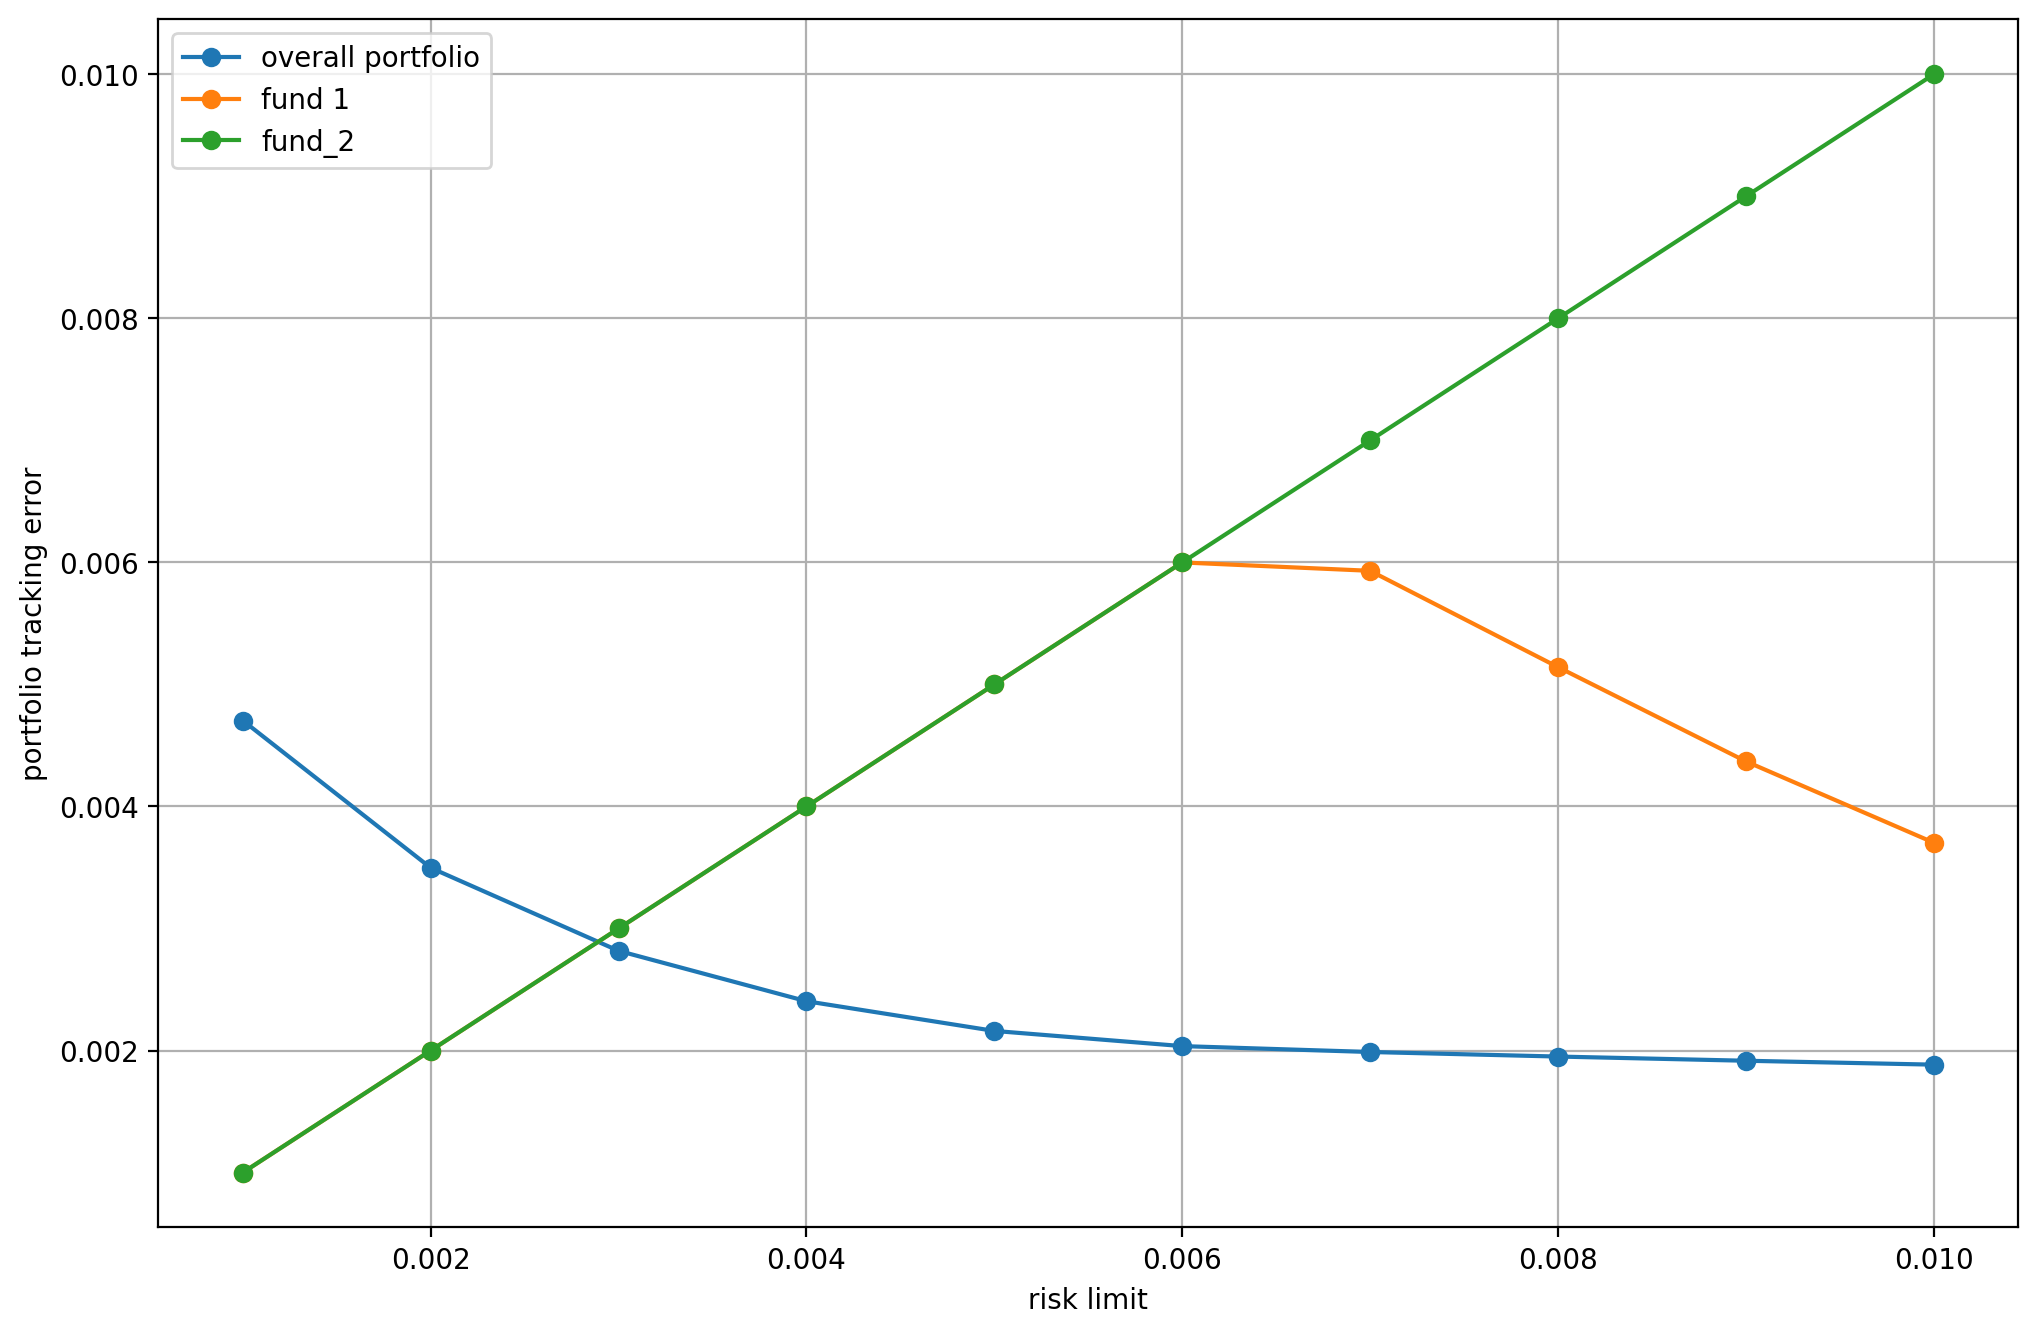

In [59]:
# Efficient frontier
ax = df_result.plot(x="s2", y="te_o", style="-o", xlabel="risk limit", ylabel="portfolio tracking error", grid=True)
df_result.plot(ax=ax, x="s2", y="te_1", style="-o", xlabel="risk limit", ylabel="portfolio tracking error", grid=True) 
df_result.plot(ax=ax, x="s2", y="te_2", style="-o", xlabel="risk limit", ylabel="portfolio tracking error", grid=True)
ax.legend(["overall portfolio", "fund 1", "fund_2"]);